In [1]:
# Copyright (C) 2024 co-pace GmbH (a subsidiary of Continental AG).
# Licensed under the BSD-3-Clause License.
# @author: Jonas Noah Michael Neuhöfer

# Comparing our proposed Student-t based robust Filter to two other robust methods

This notebook is meant as a linear and short(ish) implementation of our algorithms to give an initial proof-of-concept.

The detailed implementation and benchmarking can be found in the framework under 'src/' and its documentation under 'doc/build/html/index.html'

In [2]:
#%matplotlib widget
import numpy as np
import scipy
import sympy
import time
import tqdm
import hyperopt
import matplotlib.pyplot as plt
#plt.rcParams.update( {"text.usetex": True,} )

### An Euler–Maruyama approximation of the proposed dynamic system

We will first discuss how we will simulate the tracking problems the filters are meant to solve.
For that, we need a dynamical model describing how the state of each agent - formed by its position, 
velocity, and acceleration - develops over time.
Here we describe it by the following stochastic differential equation (SDE), which is an extended 
version of the [Singer model](https://doi.org/10.1109/TAES.1970.310128)
    $$\begin{aligned}
        \dot p(t) &= v(t),\\
        \dot v(t) &= - \beta \cdot v(t) +a(t)\\
        \dot a(t) &= - \alpha \cdot a(t) +\sigma W_t 
            \quad\quad \text{$W_t$ here is a Brownian motion/Wiener process and introduces white noise.}
    \end{aligned}$$
We will now show that a trajectory satisfying this system of equations can be brought into the form
necessary for a linear Kalman-type filter
    $$\begin{aligned}
        x_k &= F_k x_{k-1} + v_k, &\quad v_k \sim \mathcal{N}(0, Q_k)\\
        y_k &= H_k x_k + e_k, &\quad e_k \sim \mathcal{N}(0, R_k)
    \end{aligned}$$
Here the observation process to generate $y_k$ is not a problem, but the linear dependency of $x_k$ on $x_{k-1}$

For brevity, we will simply approximate these matrices by sampling intermediate steps (see e.g. the [Euler–Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method))
    $$\begin{aligned}
        x_{t+\tfrac{\Delta t}{j}} &\approx x_t
                + \frac{\Delta t}{j} \left(\begin{array}{ccc} 0 & 1 & 0 \\ 0 & -\beta & 1 \\ 0 & 0 & -\alpha \end{array}\right) x_t 
                + \left(\begin{array}{ccc} 0 \\ 0 \\ 1 \end{array}\right) \cdot \sigma \cdot \left(W_{t+\tfrac{\Delta t}{j}} - W_t\right)\\
            &= D_{\tfrac{\Delta t}{j}}x_t + H \cdot w_1 \quad\quad  \text{ where } w_1 \sim \mathcal{N}(0, \sigma^2\cdot\tfrac{\Delta t}{j})\\[5pt]
        \Rightarrow\quad x_{t+\Delta t} 
            &\approx \big(D_{\tfrac{\Delta t}{j}}\big)^j x_t + \sum_{i = 1}^j D_{\tfrac{\Delta t}{j}}^{j-i}H w_i\\
            &= \big(D_{\tfrac{\Delta t}{j}}\big)^j x_t + w^{(1,...,j)} \quad\quad  \text{ where } w^{(1,...,j)} \sim \mathcal{N}\left(0,\ \tfrac{\sigma^2 \Delta t}{j} \sum_{i = 1}^j D_{\tfrac{\Delta t}{j}}^{j-i}H \big(D_{\tfrac{\Delta t}{j}}^{j-i}H\big)^\top \right)
    \end{aligned}$$
Thus we can approximate $F_k \approx \big(D_{\tfrac{\Delta t}{j}}\big)^j$ and $R_k \approx \tfrac{\sigma^2 \Delta t}{j} \sum_{i = 1}^j D_{\tfrac{\Delta t}{j}}^{j-i}H \big(D_{\tfrac{\Delta t}{j}}^{j-i}H\big)^\top$

The exact solution of $F_k$ and $R_k$ for $\beta = 0$ is known as the [Singer model](https://doi.org/10.1109/TAES.1970.310128) and the generalized form is computed in our detailed implementation.

In [3]:
seed = 1      # the seed for sampling random processes
dt   = 0.20   # the time step between two measurments
T    = 500    # the number of timesteps in a trajectory
dim  = 2      # The dimension of the space. dim=2 describes movement on a plane. 
              # dim=3 would describe free 3-dimensional movement in space, e.g. by a drone.
              # dim can be increased to investigate performance scaling with matrix dimensions
alpha = 0.5   # the inverse timescale for a maneouvre,
              # influencing the timescale of correlated accelerations
beta = 0.25   # friction term, scaling inversely with the time needed to decelerate
              # rule of thumb: every 1/beta seconds the velocity halves (or rather 1/e)
obs_step = 1  # only every 'obs_step'th trajectory sample is observed
nu = 1.       # The degrees of freedom for the outlier-inducing student-t distribution
              # used to sample observation noise
sigmaR = 0.25 # the scale of observation noise

# Finds the F and Q matrices as described above
def FQ_ExtendedSingerApproximation(alpha=alpha, beta=beta, sigma2=1, dt=dt, dim=dim, intermediate=1000):
    k = intermediate+1
    D_approx = np.array([[1, dt/k, 0], [0, 1-beta*dt/k, dt/k], [0, 0, 1-alpha*dt/k]])
    Q = np.diag([0,0,1]) + D_approx[:,2:] @ D_approx[:,2:].T
    D_power = np.copy(D_approx)
    for i in range(k-2, 0, -1):
        D_power = D_power @ D_approx
        Q += D_power[:,2:] @ D_power[:,2:].T
    Q = sigma2*dt/k*Q
    F = D_power @ D_approx
    return (np.kron(F, np.eye(dim)), np.kron(Q, np.eye(dim)))

F, Q, = FQ_ExtendedSingerApproximation(dt=dt)

### Sampling trajectories using these F and Q matrices

Now, we can use these approximate solutions to sample random trajectories of an agent moving on a plane.
For this, we apply the ODEs above for the x and y coordinate axes independently of each other.

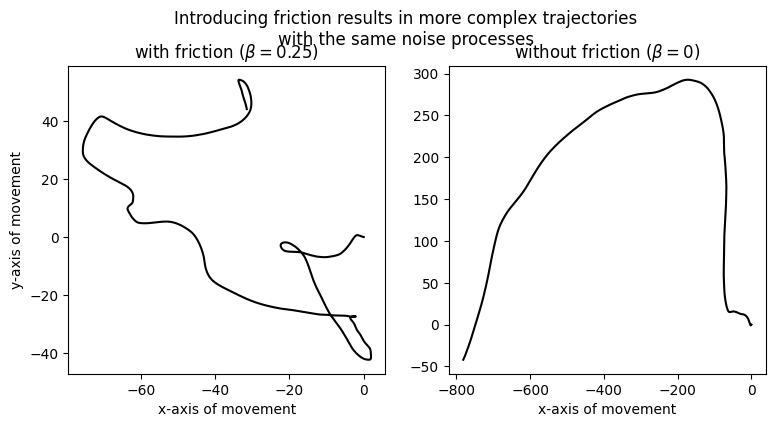

In [4]:
def sample(F, Q, x0=None, T=T*obs_step, RNG=None):
    n = Q.shape[-1]
    x = np.empty((T+1,n))
    x[0] = x0 if x0 is not None else np.zeros((n,))
    v = scipy.stats.multivariate_normal.rvs(mean=np.zeros((n,)), cov=Q, size=T, random_state=RNG)
    for i in range(T):
        x[i+1] = F @ x[i] + v[i]
    return x


x1 = sample(*FQ_ExtendedSingerApproximation(dt=dt/obs_step, beta=beta, dim=dim), RNG=seed)
x2 = sample(*FQ_ExtendedSingerApproximation(dt=dt/obs_step, beta=0, dim=dim),    RNG=seed)
fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(x1[:,0], x1[:,1], "k"); ax[0].set_title(f"with friction ($\\beta = {beta}$)")
ax[1].plot(x2[:,0], x2[:,1], "k"); ax[1].set_title("without friction ($\\beta = 0$)")
fig.subplots_adjust(hspace=0.3)
fig.suptitle("Introducing friction results in more complex trajectories\nwith the same noise processes\n", y=1.02)
ax[0].set_ylabel("y-axis of movement"); ax[0].set_xlabel("x-axis of movement"); ax[1].set_xlabel("x-axis of movement"); pass

### Adding noisy observations with outliers

The outliers will be simulated by generating the observation noise via a Student-t distribution $t_{\nu}(0, \lambda \cdot R)$. 

However, since other methods do not expect a scale matrix of a Student-t distribution but a 
covariance matrix and our method expects the scale matrix of the process noise - even if the process
noise is Gaussian - we present a scheme to approximate Student-t distributions by Gaussians and reverse.

For this, we find the value of $\lambda_{KL}$ that minimizes the Kulback-Leibler divergence between a Gaussian and 
a Student-t distribution with similarly shaped covariance/scale matrices:
$$\begin{aligned} 
    \lambda_{KL} = \text{argmin}_{a \,>\, 0} D_{KL}(\mathcal{N}(\mu, \Sigma) \| t_\nu(\mu, a\Sigma)) 
\end{aligned}$$

$\text{\textit{The following is a short summary of keynotes on how to simplify this task. It is not necessary to follow in detail.}}$<br><br>

Note that the following Kulback-Leibler divergence can be computed as
$$\begin{aligned}
	D_{KL}(\mathcal{N}(\mu, \Sigma) \| t_\nu(\mu, a\Sigma)) &= D_{KL}(\mathcal{N}(0,I_d) \| t_\nu(0, aI_d))\\
		&=\log\left( \frac{\Gamma\left(\frac{\nu}{2}\right) \cdot a^{\frac{d}{2}} \cdot \nu^{\frac{d}{2}}}{\Gamma\left(\frac{\nu+d}{2}\right) \cdot 2^{\frac{d}{2}}  }\right) - \frac{1}{2}d + \frac{\nu+d}{2} \mathbb{E}_{x \sim \mathcal{N}(0,I_d)}\!\left[\log\left(1+\frac{x^\top x}{a\nu}\right)\right] \\
		&= \log\left( \frac{\Gamma\left(\frac{\nu}{2}\right)  \nu^{\frac{d}{2}}}{2^{\frac{d}{2}} \Gamma\left(\frac{\nu+d}{2}\right) }\right) +\frac{d}{2}\log(a) - \frac{d}{2} + \frac{\nu+d}{2}  \mathbb{E}_{x \sim \Gamma\left(\tfrac{d}{2}, \tfrac{1}{2}\right)}\!\left[\log\left(1+\frac{x}{a\nu}\right)\right] \\
\end{aligned}$$

We now want to find the value of $a$ that minimises this divergence. For this, we can compute
$$ \begin{aligned}
	\frac{\partial}{\partial a} D_{KL}(\mathcal{N}(\mu, \Sigma) \| t_\nu(\mu, a\Sigma)) 
		=& \frac{(\nu+d) F_{\nu, d}(a) -\nu}{2a} \\
	F_{\nu, d}(a) 
		:=& \left(\frac{\nu a}{2}\right)^{\frac{d}{2}} e^{\frac{\nu a}{2}} \ \hat\Gamma\!\left(1-\frac{d}{2}, \frac{\nu a}{2}\right) \\
	\hat\Gamma\!\left(1-\frac{d}{2}, \frac{\nu a}{2}\right) 
		:=& \int_{\frac{\nu a}{2}}^{\infty} x^{-\frac{d}{2}}e^{-x} \ \text{d}x \quad \text{(upper incomplete gamma function)}& 
\end{aligned}$$
Furthermore,
$$
\begin{aligned}
\frac{\partial}{\partial a} F_{\nu, d}(a) &= \left(\frac{\nu}{2} + \frac{d}{2a}\right) F_{\nu, d}(a) - \frac{\nu}{2}
\end{aligned}
$$
enables us to find the minimising value of $a$ via Newtons method

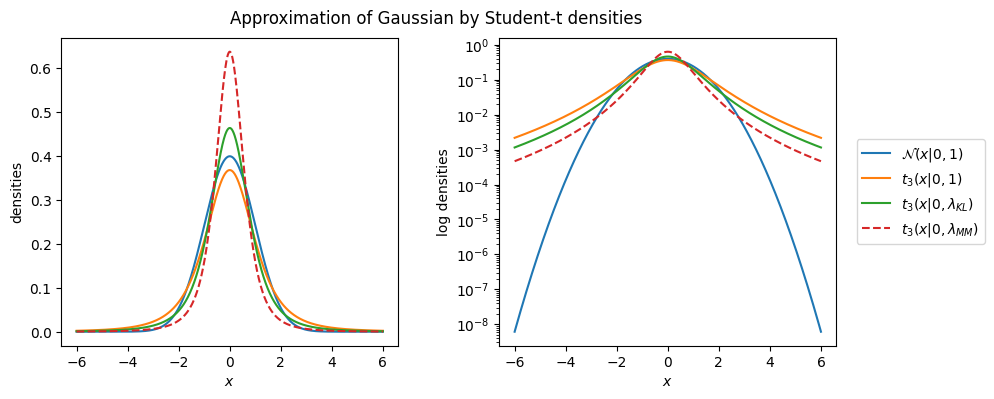

In [5]:
old_KLDmin = {} # caches previously computed values of a
def KLDmin_Norm_T(dim, nu):
    if (dim,nu) in old_KLDmin.keys():
        return old_KLDmin[(dim,nu)]
    a, a_old = (1., 0)
    while np.abs(a-a_old)/np.abs(a) > 1e-5:
        a_old = a
        uG = float(       sympy.functions.special.gamma_functions.uppergamma(1-dim/2, nu*a/2) if dim != 2 
                    else -sympy.functions.special.error_functions.Ei(-nu*a/2) )
        F_vd_a = np.exp(dim/2 *np.log(nu*a/2) + nu*a/2) * uG
        dDKL  = ( -nu + (nu+dim)*F_vd_a )/(2*a) # first derivative
        ddDKL = ( (nu+dim)*( (nu/2 +dim/(2*a))*F_vd_a -nu/2 ) )/(2*a) - dDKL/a #second derivative
        a -= dDKL/ddDKL 
        a = a if a > 1e-10 else 1e-10
    old_KLDmin[(dim,nu)] = a
    return a

fig, ax = plt.subplots(1,2, figsize=(10,4))
dim2 = 1; nu2=3
d = np.zeros((1001,dim2)); d[:,0] = np.linspace(-6,6,1001)
ax[0].plot(d[:,0], scipy.stats.multivariate_normal.pdf(d, cov=np.eye(dim2)), label="$\\mathcal{N}(x|0,1"+(f"_{dim2}"if dim2 > 1 else "")+")$")
ax[0].plot(d[:,0], scipy.stats.multivariate_t.pdf(d, df=nu2, shape=np.eye(dim2)), label=f"$t_{ {nu2}}(x|0,1"+(f"_{dim2}"if dim2 > 1 else "")+")$")
ax[0].plot(d[:,0], scipy.stats.multivariate_t.pdf(d, df=nu2, shape=KLDmin_Norm_T(dim2,nu2)*np.eye(dim2)), label=f"$t_{ {nu2}}"+"(x|0,\\lambda_{ KL}"+(f"\\cdot 1_{dim2}"if dim2 > 1 else "")+")$")
#ax[0].plot(d[:,0], scipy.stats.multivariate_t.pdf(d, df=nu2, shape=KLDmin_Norm_T(dim2,nu2)**2*np.eye(dim2)), '--', label=f"$t_{ {nu2}}"+"(x|0,\\lambda_{ KL}^2"+(f"\\cdot 1_{dim2}"if dim2 > 1 else "")+")$")
ax[1].plot(d[:,0], scipy.stats.multivariate_normal.pdf(d, cov=np.eye(dim2)), label="$\\mathcal{N}(x|0,1"+(f"_{dim2}"if dim2 > 1 else "")+")$")
ax[1].plot(d[:,0], scipy.stats.multivariate_t.pdf(d, df=nu2, shape=np.eye(dim2)), label=f"$t_{ {nu2}}(x|0,1"+(f"_{dim2}"if dim2 > 1 else "")+")$")
ax[1].plot(d[:,0], scipy.stats.multivariate_t.pdf(d, df=nu2, shape=KLDmin_Norm_T(dim2,nu2)*np.eye(dim2)), label=f"$t_{ {nu2}}"+"(x|0,\\lambda_{ KL}"+(f"\\cdot 1_{dim2}"if dim2 > 1 else "")+")$")
#ax[1].plot(d[:,0], scipy.stats.multivariate_t.pdf(d, df=nu2, shape=KLDmin_Norm_T(dim2,nu2)**2*np.eye(dim2)), label=f"$t_{ {nu2}}"+"(x|0,\\lambda_{ KL}^2"+(f"\\cdot 1_{dim2}"if dim2 > 1 else "")+")$")
if nu2 > 2:
    ax[0].plot(d[:,0], scipy.stats.multivariate_t.pdf(d, df=nu2, shape=(nu2-2)/nu2*np.eye(dim2)), "--", label=f"$t_{ {nu2}}"+"(x|0,\\lambda_{ MM}"+(f"\\cdot 1_{dim2}"if dim2 > 1 else "")+")$")
    ax[1].plot(d[:,0], scipy.stats.multivariate_t.pdf(d, df=nu2, shape=(nu2-2)/nu2*np.eye(dim2)), "--", label=f"$t_{ {nu2}}"+"(x|0,\\lambda_{ MM}"+(f"\\cdot 1_{dim2}"if dim2 > 1 else "")+")$")
#ax[0].legend()
ax[1].set_yscale("log"); ax[1].legend(loc='center left', bbox_to_anchor=(1.04,0.5))
ax[0].set_ylabel("densities");     ax[0].set_xlabel("$x$")
ax[1].set_ylabel("log densities"); ax[1].set_xlabel("$x$")
fig.subplots_adjust(wspace=0.3)
fig.suptitle("Approximation of Gaussian by Student-t densities", y=0.95); pass

Here $\lambda_{ {MM}} = \frac{\nu-2}{\nu}$ denotes the scaling, which moment-matching would recommend, i.e. the 
scaling neccessary such that $\mathcal{N}(\mu, \Sigma)$ and $t_\nu(\mu, \lambda_{ {MM}}\cdot \Sigma)$ have the same
covariances matrices.

With this approximation scheme, we can now sample measurement noise based on a Gaussian covariance matrix
(which will be approximated by a fitting Student-t scale matrix)

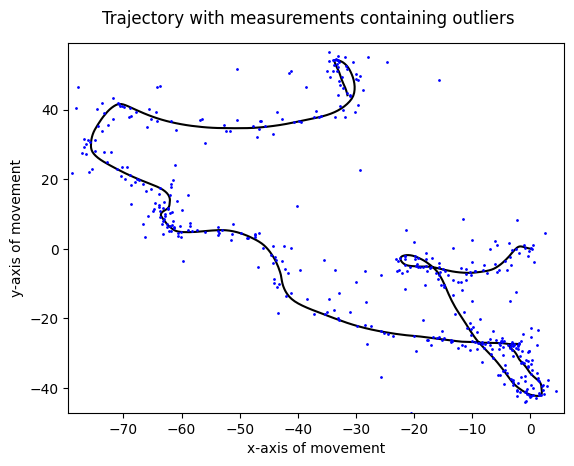

In [6]:
def get_observations(x, nu=nu, sigmaR=sigmaR, dt=dt, obs_step=obs_step, RNG=None, give_scale=False):
    d = x.shape[-1]//3
    H = np.kron(np.array([1,0,0]), np.eye(d))
    R = float(sigmaR)*np.eye(d) if type(sigmaR) in [float, int] else sigmaR
    # Rscale is the arclength of the trajectory normalised by the duration of the simulation
    Rscale = np.sqrt(np.sum((x[1:,:d]-x[:-1,:d])**2,axis=1)).sum()*obs_step/(x.shape[0]-1)/dt
    R = Rscale**2 *R
    # rescaling the noise to make comparisons for different beta values meaningful
    # i.e. the lower beta the faster the agent goes and the longer the trajectories
    # therefore we renormalise (only) the noise by the length of the trajectory
    # this basically scales noise with the average velocity
    e = scipy.stats.multivariate_t.rvs(size=(x.shape[0]-1)//obs_step, df=nu, shape=KLDmin_Norm_T(dim=d, nu=nu)*R, random_state=RNG)
    #e_norm = scipy.stats.multivariate_normal.rvs(size=x.shape[0]-1, cov=KLDmin_Norm_T(dim=d, nu=nu)*R, random_state=RNG)
    #chi = scipy.stats.chi2.rvs(df=nu, size=x.shape[0]-1)[:,None]
    #e = np.sqrt(nu/chi)*e_norm
    y = np.einsum("mn,Tn->Tm", H, x[obs_step::obs_step]) + e
    return y, H, R
y, H, R = get_observations(x1, RNG=seed,)
fig, ax = plt.subplots()
ax.plot(x1[:,0],x1[:,1], "k"); xlim = ax.get_xlim(); ylim = ax.get_ylim()
ax.plot( y[:,0], y[:,1], "bo", markersize=1); ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.set_ylabel("y-axis of movement"); ax.set_xlabel("x-axis of movement")
fig.suptitle("Trajectory with measurements containing outliers", y=0.95); pass

## Implementation of our Filter based on Student-t distributions

The filter assumes the underlying linear dynamics with Student-t distributed noise
    $$\begin{equation}\begin{array}{rll}x_k \!\!\!\!&= F_k x_{k-1} + v_k, &\quad v_k \sim t_{\nu+n+m}(0, \lambda_Q\cdot Q_k)\\
    y_k \!\!\!\!&= H_k x_k + e_k, &\quad e_k \sim t_{\nu}(0, \lambda_R\cdot R_k)\end{array}\end{equation}$$
where $n$ is the dimension of $x$, $m$ is the dimension of $y$ and estimates of $x_k$ take the form $t_{\nu+m}(\mu_k, P_k)$.
The factors $\lambda_Q$ and $\lambda_R$ are again provided by the Kulback Leibler minimization scheme,
so that our implementation can receive the same covariance parameters $R$ and $Q$ other Gaussian-based filters would expect.

Our method uses the following equation of Student-t densities, which holds for every fixed tuple $(x_{k-1}, v_k, e_k)$
    $$
    t_{\nu}(e_{k}|0, R_{k}) \cdot t_{\nu+m}\!\left( x_{k - 1} | \mu_{k - 1}, P_{k - 1}\right) \cdot  t_{\nu+m+n}\!\left( v_{k} | 0, Q_{k}\right) 
        = %\vspace{-2pt}
    t_{\nu}\!\! \left(\!  \left[\begin{array}{c} x_{k - 1}\\v_{k}\\e_{k} \end{array} \right]\right| \!\left[ \begin{array}{c} \mu_{k - 1}\\0\\0 \end{array} \right]\!,\left. \left[ \begin{array}{ccc} a(e_k) P_{k - 1}&\!\! \!\!0\!\!&\!\!0\\0&\!\! \!\!a(e_k) b(x_{k - 1}) Q_{k}\!\!&\!\!0 \\ 0&\!\! \!\!0\!\!&\!\!R_{k} \end{array} \right]\!\! \right)
    $$
where $a(e_k) = \frac{\nu+m}{\nu+e_{k}^\top R_{k}^{-1}e_{k}}$ and $b(x_{k - 1}) = \frac{\nu+m+n}{\nu+m+ (x_{k - 1} -\mu_{k - 1})^{\!\top}\! P_{k - 1}^{-1}(x_{k - 1} -\mu_{k - 1})}$.

Thus with approximations $a_k \approx a(e_k)$ and $b_k \approx b(x_{k-1})$ from the unknown values of $e_k$ and $x_{k-1}$ from (1) we can approximate the joint 
distribution of $x_{k-1}$, $v_k$ and $e_k$ by a multivariate Student-t distribution

In [7]:
def check_filter_input(F,H,Q,R,obs,x0,P0=None):
    m,n = H.shape
    assert (obs.ndim == 2 and obs.shape[1] == m), f"observations should have the shape (k, {m}) but have {obs.shape}"
    k = obs.shape[0]
    if F.shape != (n,n):
        F = np.kron(F, np.eye(n//F.shape[0]))
    if Q.shape != (n,n):
        Q = np.kron(Q, np.eye(n//Q.shape[0]))
    assert R.shape == (m,m), f"R should have shape ({m}, {m}) but has {R.shape}"
    assert F.shape == (n,n), f"F should have shape ({n}, {n}) but has {F.shape}"
    assert Q.shape == (n,n), f"Q should have shape ({n}, {n}) but has {Q.shape}"
    assert x0.shape == (n,), f"x0 should have shape ({n},) but has {x0.shape}"
    if P0 is None:
        P0 = Q
        for _ in range(4):
            P0 = F @ P0 @ F.T + Q
    assert P0.shape == (n,n), f"P0 should have shape ({n}, {n}) but has {P0.shape}"
    x = np.empty((k+1,n)); x[0] = x0
    P = np.empty((k+1,n,n)); P[0] = P0

    return k, n, m, F, Q, x, P

def STF(F,H,Q,R,obs,x0,P0=None, nu=2.8055, Ps=1,Qs=1,Rs=1):
    k, n, m, F, Q, x, P = check_filter_input(F=F,H=H,Q=Q,R=R,obs=obs,x0=x0,P0=P0)

    # transform the initial model parameters from their Gaussian based covariances to 
    #  their best approximating Student-t based scale matrices
    P[0]*=  Ps*KLDmin_Norm_T(dim=n, nu=nu+m)
    Q    = (Qs*KLDmin_Norm_T(dim=n, nu=nu+m+n)) *Q
    R    = (Rs*KLDmin_Norm_T(dim=m, nu=nu)) *R

    QH    = Q @ H.T
    HQH   = H @ QH

    Id_m = np.eye(m) # often used identity matrix

    for i in range(k):
        x_pri = F @ x[i]
        residual = obs[i] - H @ x_pri
        # necessary matrix-matrix multiplications
        FPF   = F @ P[i] @ F.T
        FPFH  = FPF @ H.T
        HFPFH = H @ FPFH
        # initial estimates of a and b
        a = (nu + m) / (nu + (residual @ scipy.linalg.solve(R, residual, check_finite=False, assume_a='pos')))
        b = (nu + m + n) / (nu + m + max(n-2,0) *(nu+m)/(nu+m+2))
        it = 0
        while it < 100:
            S_inv = scipy.linalg.solve( a*HFPFH + (a*b)*HQH + R, Id_m, check_finite=False, assume_a='pos')
            Sr = S_inv @ residual
            cov_scale = (nu + (residual.T @ Sr))/(nu + m -2)
            a_approx = (nu + m) / (nu + cov_scale*(m - np.sum(R * S_inv))/2 + (Sr.T @ R @ Sr))
            b_approx = (nu + m + n) / (nu + m + cov_scale*a*(n  - a*np.sum(HFPFH * S_inv))/2 + (a*a) * (Sr.T @ HFPFH @ Sr))
            if abs(a_approx - a)/(a_approx+a) + abs(b_approx - b)/(b_approx+b) < 2e-2:
                break
            a, b, it = (a_approx, b_approx, it+1)

        P_pri  = (a*FPF  + (a*b)*Q)
        P_priH = (a*FPFH + (a*b)*QH)
        K = P_priH @ S_inv

        x[i+1] = x_pri + K @ residual
        c = cov_scale * (nu+m-2)/(nu+m)
        P[i+1] = c * (P_pri - K @ P_priH.T)
    return x, P, nu+m

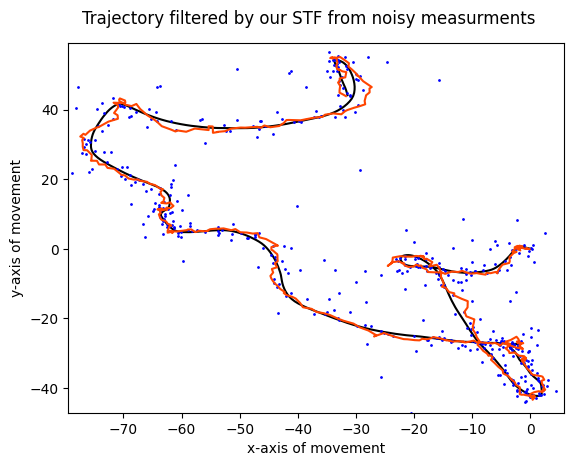

In [8]:
Pinit = Q
for _ in range(4):
    Pinit = F @ Pinit @ F.T + Q
xinit = scipy.stats.multivariate_normal.rvs(mean=x1[0], cov=Pinit, random_state=seed)
xSTF, PSTF, nuSTF = STF(F=F,H=H,Q=Q,R=R,obs=y,x0=xinit,P0=Pinit)
fig, ax = plt.subplots()
ax.plot(x1[:,0],x1[:,1], "k"); xlim = ax.get_xlim(); ylim = ax.get_ylim()
ax.plot( y[:,0], y[:,1], "bo", markersize=1); ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.plot(xSTF[:,0],xSTF[:,1], color="#ff4500")
ax.set_ylabel("y-axis of movement"); ax.set_xlabel("x-axis of movement")
fig.suptitle("Trajectory filtered by our STF from noisy measurments", y=0.95); pass

For comparison, we also give the implementations of two other state-of-the-art robust filters ([by Huang et al.](https://doi.org/10.1109/TAC.2020.3011443) and [by Agamennoni et al.](https://doi.org/10.1109/ICRA.2011.5979605)) 
as well as the gated Kalman Filter. 

The gated Kalman Filter assumes that non-outlier measurements $y_k$ are distributed according to $\mathcal{N}(F\mu_{k-1}, \overbrace{HF P_{k-1} F^\top H^\top + H Q H^\top +R}^{:= S_k})$.
Thus the Mahalanobis distance $(y_k - F\mu_{k-1})^\top S^{-1} (y_k - F\mu_{k-1}) \sim \chi^2(m)$ is chi-squared distributed, where $m$ is the dimension of $y_k$.
Thus, the probability of seeing an observation with smaller Mahalanobis distance than some threshold $\alpha$ can be computed from the cumulative distribution function (CDF)
$$\mathbb{P}((y_k - F\mu_{k-1})^\top S^{-1} (y_k - F\mu_{k-1}) < \alpha) = \int_0^\alpha \chi^2(x;m)\,\text{d}x.$$

Vice versa, if we are given a maximal such probability $p_{gating}$ after which an observation $y_k$ is considered an outlier,
we can calculate the corresponding threshold $\alpha$ by the inverse CDF.

In [9]:
def gated_KF(F,H,Q,R,obs,x0,P0=None, p_gating=0.9785,Ps=1,Qs=1,Rs=1):
    k, n, m, F, Q, x, P = check_filter_input(F=F,H=H,Q=Q,R=R,obs=obs,x0=x0,P0=P0)
    gating_thres = scipy.stats.chi2(m).ppf(p_gating)
    P[0]*= Ps
    Q    = Qs*Q
    R    = Rs*R
    #R    = (1.5*Rs)*R

    for i in range(k):
        x_pri = F @ x[i]
        residual = obs[i] - H @ x_pri
        # necessary matrix-matrix multiplications
        P_pri  = F @ P[i] @ F.T + Q
        P_priH = P_pri @ H.T
        HP_priH= H @ P_priH
        if p_gating > 1-1e-10 or (residual.T @ scipy.linalg.solve( HP_priH + R, residual, check_finite=False, assume_a='pos') < gating_thres):
            # not a detected outlier
            K = P_priH @ scipy.linalg.solve( HP_priH + R, np.eye(m), check_finite=False, assume_a='pos')
            x[i+1] = x_pri + K @ residual
            P[i+1] = P_pri - K @ P_priH.T
        else:
            x[i+1] = x_pri
            P[i+1] = P_pri
    return x, P

def Agamennoni(F,H,Q,R,obs,x0,P0=None, nu=6.546, p_gating=1,Ps=1,Qs=1,Rs=1):
    k, n, m, F, Q, x, P = check_filter_input(F=F,H=H,Q=Q,R=R,obs=obs,x0=x0,P0=P0)
    gating_thres = scipy.stats.chi2(m).ppf(p_gating)
    P[0]*=  Ps
    Q    =  Qs *Q
    R    =  Rs *R #(Rs*KLDmin_Norm_T(dim=m, nu=nu/2)) *R
    Id_m = np.eye(m) # often used identity matrix
    Id_n = np.eye(n) # often used identity matrix

    for i in range(k):
        x_pri = F @ x[i]
        residual = obs[i] - H @ x_pri
        # necessary matrix-matrix multiplications
        P_pri  = F @ P[i] @ F.T + Q
        P_priH = P_pri @ H.T
        HP_priH= H @ P_priH
        it = 1
        if p_gating > 1-1e-10 or (residual.T @ scipy.linalg.solve( HP_priH + R, residual, check_finite=False, assume_a='pos') < gating_thres):
            # not a detected outlier
            Gl = R
            norm_Gl = np.sqrt((Gl**2).sum())
            while it < 100:
                S    = scipy.linalg.solve(HP_priH + Gl, Id_m, check_finite=False, assume_a='pos')
                PHS  =  P_priH @ S
                HPHS = HP_priH @ S
                GlS  = Gl @ S
                # better estimations of Gl (Gamma in the paper) only require better approximations of
                # H Sigma H (C^T Sigma C in the paper) and not Sigma directly, which simplifies the formula
                HSigmaH = HPHS @ Gl @ HPHS.T + GlS @ HP_priH @ GlS.T
                HSigmaH = (HSigmaH + HSigmaH.T)/2
                # d = obs - Hμ = obs - HFm - HPHS @ res = res - HPHS @ res
                d   = residual - HPHS @ residual
                G   =  ( (nu-1)* R + d[None,:] * d[:,None] + HSigmaH) / nu
                G   = (G + G.T)/2
                norm_G = np.sqrt((G**2).sum())
                if  ((G-Gl)**2).sum()**0.5 / (norm_G + norm_Gl)  <  1e-3:
                    x[i+1] = x_pri + PHS @ residual
                    ImHSHP = Id_n - H.T @ PHS.T
                    P[i+1] = PHS @ G @ PHS.T + ImHSHP.T @ P_pri @ ImHSHP
                    break
                Gl = G
                norm_Gl = norm_G
                it += 1
        else:
            x[i+1] = x_pri
            P[i+1] = P_pri
        P[i+1] = (P[i+1]+P[i+1].T)/2
    return x, P

def SSMKF_log_S(F,H,Q,R,obs,x0,P0=None, nu=4.007, delta=1e-8, Ps=1,Qs=1,Rs=1):
    k, n, m, F, Q, x, P = check_filter_input(F=F,H=H,Q=Q,R=R,obs=obs,x0=x0,P0=P0)
    P[0]*=  Ps
    Q    = Qs *Q
    R    = Rs *R
    dfx, dfy = (lambda t: -(nu + n)/(nu + t)/2, lambda t: -(nu + m)/(nu + t)/2 )
    
    for i in range(k):
        xi, lamb = (1.,1.)
        x_pri = F @ x[i]
        residual = obs[i] - H @ x_pri
        # necessary matrix-matrix multiplications
        P_pri  = F @ P[i] @ F.T + Q
        P_priH = P_pri @ H.T
        HP_priH= H @ P_priH
        Rinv = scipy.linalg.solve(R, np.eye(m), check_finite=False, assume_a='pos')
        Pinv = scipy.linalg.solve(P_pri, np.eye(n), check_finite=False, assume_a='pos')
        for _ in range(30):
            S = scipy.linalg.solve(HP_priH/xi + R/lamb, np.eye(m), check_finite=False, assume_a='pos')
            HK = HP_priH/xi @ S
            res_new = residual - HK @ residual
            B = res_new[:,None] * res_new[None,:] + HP_priH/xi - HK @ HP_priH.T/xi
            # remember that trace(A @ B) = \sum_ij A_ij * B_ij
            lamb_new = -2 * dfy( np.sum(B*Rinv) )
            lamb_new = lamb_new if lamb_new > delta else delta
            if abs(lamb_new-lamb)/lamb < 1e-6:
                break
            lamb = lamb_new
        for _ in range(30):
            S = scipy.linalg.solve(HP_priH/xi + R/lamb, np.eye(m), check_finite=False, assume_a='pos')
            K = P_priH/xi @ S
            ino = K @ residual
            A = ino[:,None] * ino[None,:] + P_pri/xi - K @ P_priH.T/xi

            xi_new = -2 * dfx( np.sum(A*Pinv) )
            xi_new = xi_new if xi_new > delta else delta
            if abs(xi_new-xi)/xi < 1e-6:
                break
            xi = xi_new

        #S = np.linalg.solve(HPH/xi + _R/lamb, np.eye(m))
        S = scipy.linalg.solve(HP_priH/xi + R/lamb, np.eye(m), check_finite=False, assume_a='pos')
        K = P_priH/xi @ S
        x[i+1] = x_pri + K @ residual
        P[i+1] = P_pri/xi - K @ P_priH.T/xi
    return x, P        


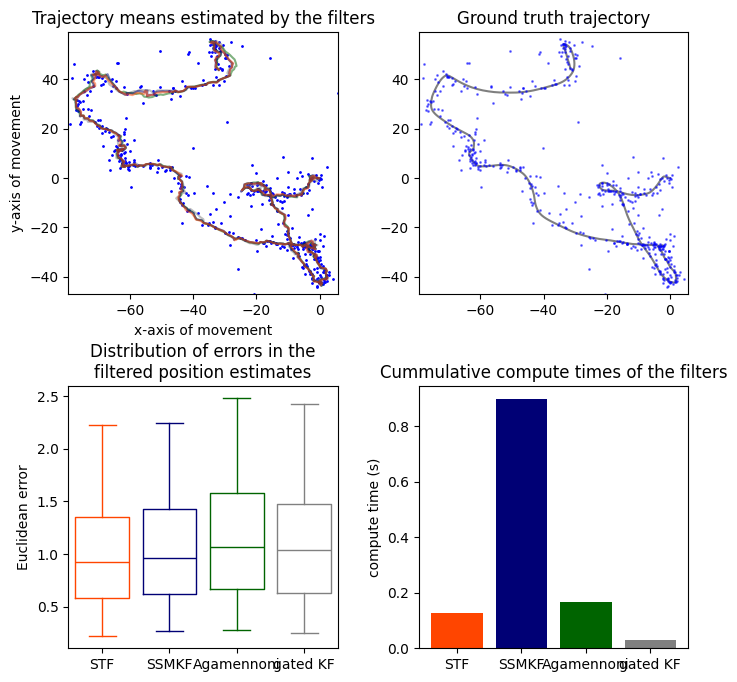

In [10]:
comp_time = []
curr_time = time.process_time()
xSTF, PSTF, nuSTF = STF(F=F,H=H,Q=Q,R=R,obs=y,x0=xinit,P0=Pinit)
comp_time.append(time.process_time()-curr_time); curr_time = time.process_time()
xSSM, PSSM = SSMKF_log_S(F=F,H=H,Q=Q,R=R,obs=y,x0=xinit,P0=Pinit)
comp_time.append(time.process_time()-curr_time); curr_time = time.process_time()
xAga, PAga = Agamennoni(F=F,H=H,Q=Q,R=R,obs=y,x0=xinit,P0=Pinit)
comp_time.append(time.process_time()-curr_time); curr_time = time.process_time()
xGKF, PGKF = gated_KF(F=F,H=H,Q=Q,R=R,obs=y,x0=xinit,P0=Pinit)
comp_time.append(time.process_time()-curr_time)

# visualisation
fig, ax = plt.subplots(2,2,figsize=(8,8))
#ax[0,0].plot(x1[:,0],x1[:,1], "k"); xlim = ax[0,0].get_xlim(); ylim = ax[0,0].get_ylim()
ax[0,0].plot( y[:,0], y[:,1], "bo", markersize=1); ax[0,0].set_xlim(xlim); ax[0,0].set_ylim(ylim)
ax[0,1].plot(x1[:,0],x1[:,1], "k", alpha=0.5)
ax[0,1].plot( y[:,0], y[:,1], "bo", markersize=1, alpha=0.5); ax[0,1].set_xlim(xlim); ax[0,1].set_ylim(ylim)
ax[0,0].plot(xGKF[:,0],xGKF[:,1], color="grey", label="gated KF", alpha=0.5)
ax[0,0].plot(xAga[:,0],xAga[:,1], color="#006400", label="Agamennoni", alpha=0.5)
ax[0,0].plot(xSSM[:,0],xSSM[:,1], color="#000075", label="SSMKF-log-S", alpha=0.5)
ax[0,0].plot(xSTF[:,0],xSTF[:,1], color="#ff4500", label="our STF", alpha=0.5)
ax[0,0].set_ylabel("y-axis of movement"); ax[0,0].set_xlabel("x-axis of movement")
ax[0,0].set_title("Trajectory means estimated by the filters")
ax[0,1].set_title("Ground truth trajectory")
#ax[0,0].legend( )

for i in range(4):
    error = np.sqrt(np.sum((([xSTF[1:], xSSM[1:], xAga[1:], xGKF[1:]][i]-x1[obs_step::obs_step])**2)[1:,:2], axis=1))
    boxplot = ax[1,0].boxplot(error, positions=[i], widths=[0.8], whis=[5,95], showfliers=False)
    color=["#ff4500","#000075","#006400","grey",][i]
    for name in ['whiskers', 'caps', 'boxes', 'medians']:
        for line in boxplot[name]:
            line.set(color=color)
    if i < 3:
        ylims = ax[1,0].get_ylim()
ax[1,0].set_ylim(ylims)
ax[1,0].set_title("Distribution of errors in the\nfiltered position estimates")
ax[1,0].set_xticks([i for i in range(4)],["STF", "SSMKF", "Agamennoni", "gated KF"])
ax[1,0].set_ylabel("Euclidean error")

for i in range(4):
    ax[1,1].bar(i, comp_time[i], width=0.8, color=["#ff4500","#000075","#006400","grey",][i])
ax[1,1].set_title("Cummulative compute times of the filters")
ax[1,1].set_xticks([i for i in range(4)],["STF", "SSMKF", "Agamennoni", "gated KF"])
ax[1,1].set_ylabel("compute time (s)")
fig.subplots_adjust(hspace=0.35, wspace=0.3)
pass

### Simple Quantitative Comparison

Finally, the following is a simple quantitative analysis, where we calculate the errors in the 
estimated positions over multiple trajectories.

In [11]:
def run_filter(filter, N, RNG,error, pos_lik, likelih, comp_time, filter_params={},
               dt=dt, T=T, dim=dim, obs_step=obs_step, Rnu=nu, alpha=alpha, beta=beta, 
               F=None, Q=None, interF=None, interQ=None, pbar=None, use_framework=False):
    if F is None or Q is None:
        F, Q = FQ_ExtendedSingerApproximation(alpha=alpha, beta=beta, dt=dt, dim=dim)
    if obs_step==1:
        interF, interQ = F, Q
    elif interF is None or interQ is None:
        interF, interQ = FQ_ExtendedSingerApproximation(alpha=alpha, beta=beta, dt=dt/obs_step, dim=dim)

    Pinit = Q
    for _ in range(4):
        Pinit = F @ Pinit @ F.T + Q

    for i in range(N):
        if not use_framework:
            xN = sample(interF, interQ, T=T*obs_step, RNG=RNG)[::obs_step]
            xinit = scipy.stats.multivariate_normal.rvs(mean=xN[0], cov=Pinit, random_state=RNG)
            yN, H, R = get_observations(xN, nu=Rnu, sigmaR=sigmaR, dt=dt, obs_step=1, RNG=RNG)
        else: # Use Framework generated trajectories instead
            try:
                from src.eval.simulate import simulate_Singer
            except Exception:
                import sys
                sys.path.insert(0, '~/code/STF') 
                #print("Sys path:  ", sys.path)
                from src.eval.simulate import simulate_Singer
            model, (x0, P0), (x,y,v,e,t) = simulate_Singer(seed=RNG, dt=dt, T=T, R_nu=nu, alpha=alpha, beta=beta, sigmaR=sigmaR)
            xinit = x0
            Pinit = P0
            xN = x[:,:,0]
            yN = y[:,:,0]
            F = model._F(dt)
            Q = model._Q(dt)
            H = model._H
            R = model._R

        curr_time = time.process_time()
        try:
            xfilt, Pfilt, *_ = filter(F=F,H=H,Q=Q,R=R,obs=yN,x0=xinit,P0=Pinit, **filter_params)
            comp_time[i] = (time.process_time()-curr_time)
            error[i] = np.sqrt(np.sum(((xfilt-xN)**2)[1:,:2], axis=1))
            if filter in [STF]:
                for k in range(T):
                    pos_lik[i,k] = scipy.stats.multivariate_t.logpdf(df=_[0], x=(xfilt-xN)[1+k,:2], shape=Pfilt[1+k,:2,:2])
                    likelih[i,k] = scipy.stats.multivariate_t.logpdf(df=_[0], x=(xfilt-xN)[1+k],    shape=Pfilt[1+k])
            else:
                for k in range(T):
                    pos_lik[i,k] = scipy.stats.multivariate_normal.logpdf((xfilt-xN)[1+k,:2], cov=Pfilt[1+k,:2,:2])
                    likelih[i,k] = scipy.stats.multivariate_normal.logpdf((xfilt-xN)[1+k],    cov=Pfilt[1+k])
        except Exception as e: 
            print(f"Filter {filter.__name__} threw error: {e}")
            error[i] = np.PINF
            continue
        if pbar is not None:
            pbar.update()

def obj_values(error, pos_lik, likelih, comp_time):
    # quantifies performance, i.e. finds three values that should be as small as possible
    # evaluating euclidean errors, likelihood of ground truth state in the estimate, and 
    # likelihood of the ground truth positions. The main attention is put on the euclidean error
    succeded = np.isfinite(error)
    # These values are chosen such that the method using ground truth knowledge on a and b
    # is scaled to 1 and the normal STF method to 2 in all metrics (in a prior run)
    # such that all three metrics should be projected onto the same scale and minimising the worst
    # is sensible
    return [(np.mean(error[succeded].flatten()  )-1.5246/2)/0.2466*2, 
            (np.mean(likelih[succeded].flatten())+4.7304)/-0.6634, 
            (np.mean(pos_lik[succeded].flatten())+0.5647)/-0.6902 *2/2.5 ]

# the filters we would like to compare.
# The tuples consist of 
#   1) the filter-function, 
#   2) its representative color,
#   3) additional parameters for the filter function
filters_to_test = [
    #(STF,'#ff4500', {'Rs': 0.6876, 'nu': 3.5033}), 
    (STF,'#ff4500', {'Rs': 1, 'nu': 3.3827}), 
    #(SSMKF_log_S, '#000075', {'Rs': 0.6604, 'nu': 3.121}), 
    (SSMKF_log_S, '#000075', {'Rs': 1, 'nu': 3.402}),
    #(Agamennoni, '#006400', {'Rs': 0.7113, 'nu': 7.3648}), 
    (Agamennoni, '#006400', {'Rs': 1, 'nu': 6.6205}), 
    #(gated_KF, 'grey', {'Rs': 1.1373, 'p_gating': 0.9988}), 
    (gated_KF, 'grey', {'Rs': 1, 'p_gating': 0.9901}),
]

def qualitative_comparison(N=100, T=T, dt=dt, dim=dim, alpha=alpha, beta=beta, obs_step=obs_step, Rnu=nu,
                           seed=seed, filters_to_test=filters_to_test,use_framework=False):
    #N: how many trajectories should be sampled per boxplot
    #T: how many timesteps should be used per trajectory
    #Rss: the different scalings that should be used for R, e.g. np.linspace(2/3,4/3,7) 
    #     to check on the validiy of the KL-divergence approximation
    #dim: the dimension of the dynamical model
    #seed: the seed for the initial RNG
    fig, ax = plt.subplots(2,2, figsize=(6+len(filters_to_test), 8))
    ax = ax.flatten()
    #ax.set_yscale("log")
    pos = 0
    error = np.empty((N,T), dtype=float)
    pos_lik = np.empty((N,T), dtype=float)
    likelih = np.empty((N,T), dtype=float)
    comp_time = np.empty((N,), dtype=float)
    F, Q = FQ_ExtendedSingerApproximation(alpha=alpha, beta=beta, dt=dt, dim=dim)
    interF, interQ = FQ_ExtendedSingerApproximation(alpha=alpha, beta=beta, dt=dt/obs_step, dim=dim)

    pbar = tqdm.tqdm(total=len(filters_to_test)*N)
    hline_drawn = False
    for filter, color, params in filters_to_test:
        pbar.set_description(filter.__name__)
        RNG = np.random.default_rng(seed)
        run_filter(filter=filter, filter_params=params, N=N, RNG=RNG, pbar=pbar,
                   error=error, pos_lik=pos_lik, likelih=likelih, comp_time=comp_time,
                   dt=dt, T=T, dim=dim, obs_step=obs_step, Rnu=Rnu, use_framework=use_framework,
                   alpha=alpha, beta=beta, F=F, Q=Q, interF=interF, interQ=interQ)
        #objective_vals = obj_values(error=error, pos_lik=pos_lik, likelih=likelih, comp_time=comp_time)
        #print(f"{filter.__name__} testing hyperparameters {', '.join(f'{key}: {val:.4f}' for key,val in params.items())}"
        #    + f" - opt vals: {objective_vals[0]:.4f}, {objective_vals[1]:.4f}, {objective_vals[2]:.4f}")
        
        succeded = np.isfinite(error)
        boxplot = ax[0].boxplot(error[succeded].flatten(), positions=[pos], widths=[0.8], whis=[5,95], showfliers=False)
        boxlike = ax[1].boxplot(likelih[succeded].flatten(), positions=[pos], widths=[0.8], whis=[5,95], showfliers=False)
        boxlpos = ax[2].boxplot(pos_lik[succeded].flatten(), positions=[pos], widths=[0.8], whis=[5,95], showfliers=False)
        boxtime = ax[3].boxplot(comp_time, positions=[pos], widths=[0.8], whis=[5,95], showfliers=False)
        pos += 1
        if not hline_drawn and filter.__name__ == "STF":
            for axidx in range(3):
                ax[axidx].axhline([boxplot, boxlike, boxlpos, boxtime][axidx]['medians'][0].get_ydata()[0], alpha=.5, color="grey")
                ax[axidx].set_xticks([],[])
            hline_drawn = True
        for box in [boxplot, boxlpos, boxlike, boxtime]:
            for name in ['whiskers', 'caps', 'boxes', 'medians']:
                for line in box[name]:
                    line.set(color=color)
        if filter != gated_KF:
            ylims = [ax[i].get_ylim() for i in range(4)]
    ylims[3] = (0, ylims[3][1])
    for axidx in range(4):
        ax[axidx].set_xticks([i for i in range(len(filters_to_test))],
                             [f.__name__.split("_")[0]+(f"\nopt Rs={p['Rs']:.2f}" if ("Rs"in p and abs(p["Rs"]-1)>1e-4) else f"\nRs={p['Rs']:.2f}") 
                              for f,c,p in filters_to_test])
        ax[axidx].set_ylim(ylims[axidx])
    ax[0].set_title("Distribution of euclidean errors in the\nfiltered position estimates")
    ax[1].set_title("Distribution of ground truth likelihoods\n in the filtered estimates")
    ax[2].set_title("Distribution of ground truth likelihoods\n in the filtered position estimates")
    ax[3].set_title("Distribution of compute times\n of the filters")
    fig.tight_layout()
    pbar.close()

gated_KF: 100%|██████████| 400/400 [03:25<00:00,  1.94it/s]   


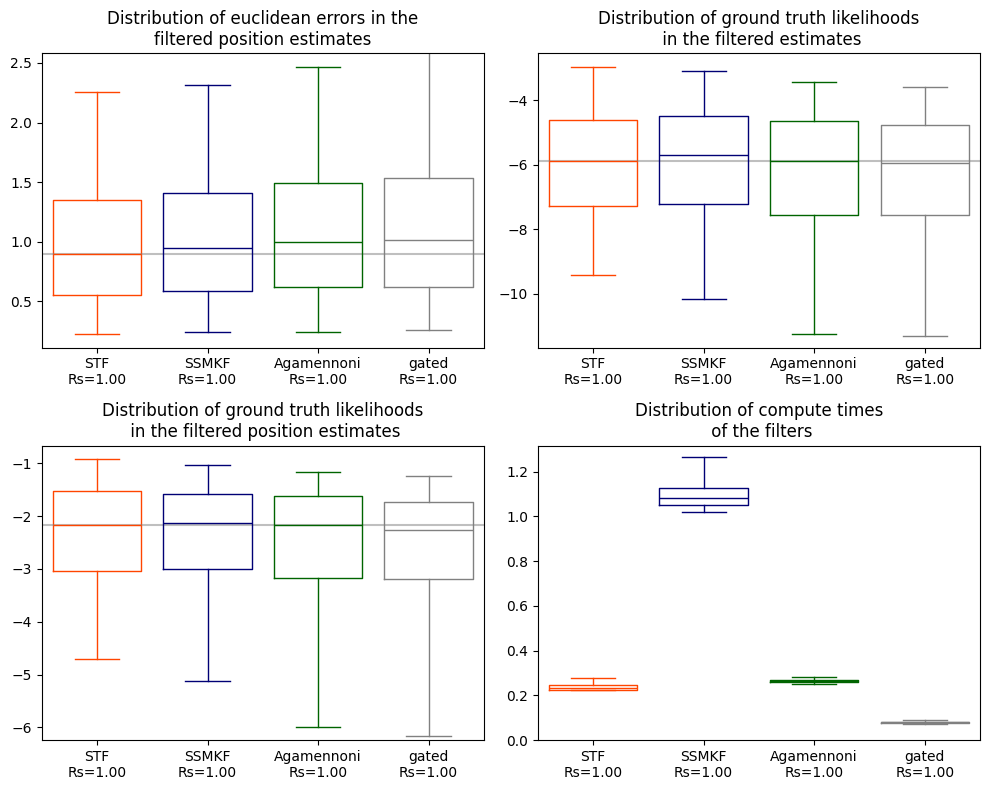

In [12]:
if True:
    qualitative_comparison(N=100)
    #qualitative_comparison(N=100, use_framework=True) # just a test that the trajectory sampling is consistent

### Using Hyperopt to optimise hyperparameters

In [13]:
def optimise_hyperparameter(filter, opt_param_search_spaces, params={}, N=100, seed=seed, max_evals=100,
                            dt=dt, T=T, dim=dim, obs_step=obs_step, Rnu=nu, alpha=alpha, beta=beta):
    error = np.empty((N,T), dtype=float)
    pos_lik = np.empty((N,T), dtype=float)
    likelih = np.empty((N,T), dtype=float)
    comp_time = np.empty((N,), dtype=float)
    F, Q = FQ_ExtendedSingerApproximation(alpha=alpha, beta=beta, dt=dt, dim=dim)
    interF, interQ = FQ_ExtendedSingerApproximation(alpha=alpha, beta=beta, dt=dt/obs_step, dim=dim)
    pbar = tqdm.tqdm(total=N*max_evals)
    def objective_function(opt_params):
        RNG = np.random.default_rng(seed)
        error[:5,-5:] = 0
        run_filter(filter=filter, filter_params=dict(opt_params,**params), N=N, RNG=RNG, pbar=pbar,
                   error=error, pos_lik=pos_lik, likelih=likelih, comp_time=comp_time,
                   dt=dt, T=T, dim=dim, obs_step=obs_step, Rnu=Rnu,
                   alpha=alpha, beta=beta, F=F, Q=Q, interF=interF, interQ=interQ)
        objective_vals = obj_values(error=error, pos_lik=pos_lik, likelih=likelih, comp_time=comp_time)
        argmax = np.argmax(objective_vals)
        pbar.set_description(f"{filter.__name__} testing hyperparameters {', '.join(f'{key}: {val:.4f}' for key,val in opt_params.items())}"
                           + f" - opt vals: {'!'if argmax==0 else ''}{objective_vals[0]:.4f}, {'!'if argmax==1 else ''}{objective_vals[1]:.4f}, {'!'if argmax==2 else ''}{objective_vals[2]:.4f}")
        return objective_vals[argmax]

    best_params = hyperopt.fmin(fn=objective_function, space=opt_param_search_spaces, 
                                algo=hyperopt.tpe.suggest, max_evals=max_evals,
                                rstate=np.random.default_rng(seed),
                                verbose=False) #no progress bar
    print(f"{filter.__name__} best params: {best_params}")
    pbar.close()
    return best_params

In [14]:
if False:
    opt_N = 100
    opt_T = T
    opt_max_evals = 50
    #STF best params: {'Rs': 0.6876, 'nu': 3.5033000000000003}
    #SSMKF_log_S best params: {'Rs': 0.6604, 'nu': 3.121}
    #Agamennoni best params: {'Rs': 0.7113, 'nu': 7.364800000000001}
    #gated_KF best params: {'Rs': 1.1373, 'p_gating': 0.9988}
    #STF best params: {'nu': 3.3827000000000003}
    #SSMKF_log_S best params: {'nu': 3.402}
    #Agamennoni best params: {'nu': 6.620500000000001}
    #gated_KF best params: {'p_gating': 0.9901000000000001}
    optimise_hyperparameter(STF, {"nu":hyperopt.hp.qnormal("nu",mu=3.5,sigma=0.4,q=0.0001)  , "Rs":hyperopt.hp.quniform("Rs",0.25,1.25,0.0001)}, 
                            params={}, N=opt_N, T=opt_T, seed=seed, max_evals=opt_max_evals)
    optimise_hyperparameter(SSMKF_log_S, {"nu":hyperopt.hp.qnormal("nu",mu=3.5,sigma=0.4,q=0.0001)  , "Rs":hyperopt.hp.quniform("Rs",0.25,1.25,0.0001)}, 
                            params={}, N=opt_N, T=opt_T, seed=seed, max_evals=opt_max_evals)
    optimise_hyperparameter(Agamennoni, {"nu":hyperopt.hp.qnormal("nu",mu=10,sigma=0.6,q=0.0001)  , "Rs":hyperopt.hp.quniform("Rs",0.25,1.25,0.0001)}, 
                            params={}, N=opt_N, T=opt_T, seed=seed, max_evals=opt_max_evals)
    optimise_hyperparameter(gated_KF, {"p_gating":hyperopt.hp.quniform("p_gating",0.95,1+1e-6,q=0.0001)  , "Rs":hyperopt.hp.quniform("Rs",0.5,1.5,0.0001)}, 
                            params={}, N=opt_N, T=opt_T, seed=seed, max_evals=opt_max_evals)
    optimise_hyperparameter(STF, {"nu":hyperopt.hp.qnormal("nu",mu=3.5,sigma=0.4,q=0.0001)}, 
                            params={}, N=opt_N, T=opt_T, seed=seed, max_evals=opt_max_evals)
    optimise_hyperparameter(SSMKF_log_S, {"nu":hyperopt.hp.qnormal("nu",mu=3.5,sigma=0.4,q=0.0001)}, 
                            params={}, N=opt_N, T=opt_T, seed=seed, max_evals=opt_max_evals)
    optimise_hyperparameter(Agamennoni, {"nu":hyperopt.hp.qnormal("nu",mu=10,sigma=0.6,q=0.0001)}, 
                            params={}, N=opt_N, T=opt_T, seed=seed, max_evals=opt_max_evals)
    optimise_hyperparameter(gated_KF, {"p_gating":hyperopt.hp.quniform("p_gating",0.95,1+1e-6,q=0.0001)}, 
                            params={}, N=opt_N, T=opt_T, seed=seed, max_evals=opt_max_evals)